# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

import OncoMark as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_90344/3695767798.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2024-02-22 03:21:07|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

# Expression in tumor vs Normal

In [3]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=100, sample_type="Tumor", genes=["IGSF8"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","subtype", "samples.sample_type"]])

patient_data_TCGA_normal = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                              metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                              filter_samples=10, sample_type="Normal", genes=["IGSF8"])
IGSF8_normal = patient_data_TCGA_normal.to_df().join(patient_data_TCGA_normal.obs[["project_id","subtype", "samples.sample_type"]])

IGSF8 = pd.concat([IGSF8_tumor, IGSF8_normal])
IGSF8 = IGSF8[~IGSF8['project_id'].isin(['LAML', "DLBC"])]

2024-02-22 03:21:07|INFO|dataloader|Dropping duplicates...
2024-02-22 03:21:07|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-22 03:21:07|INFO|dataloader|Take Tumor samples only.
2024-02-22 03:21:07|INFO|dataloader|Take gene expression data of ['IGSF8']
2024-02-22 03:21:07|INFO|dataloader|Filtering out patients with < 100 samples...
2024-02-22 03:21:08|INFO|dataloader|Dropping duplicates...
2024-02-22 03:21:08|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-22 03:21:08|INFO|dataloader|Take Normal samples only.
2024-02-22 03:21:08|INFO|dataloader|Take gene expression data of ['IGSF8']
2024-02-22 03:21:08|INFO|dataloader|Filtering out patients with < 10 samples...


In [4]:
IGSF8 = IGSF8.query('subtype!="BRCA_Normal"')
IGSF8['sample_type'] = IGSF8['samples.sample_type'].map({"Solid Tissue Normal": "Normal"}).fillna("Tumor")
IGSF8['Xlabel'] = IGSF8['project_id'].copy()
IGSF8 = IGSF8[IGSF8['Xlabel'].notna()]
IGSF8["Xlabel"] = IGSF8["Xlabel"].str.replace("_", "-")
IGSF8['xtick'] = [str(v[0]) + "." + str(v[1]) for v in IGSF8[["Xlabel", "sample_type"]].values]

In [5]:
# from statsmodels.stats.multitest import multipletests

results = pd.DataFrame(index=IGSF8['Xlabel'].unique(), columns=["tstat", "pval", "median1", "median2", "sample_size1", "sample_size2", "diff_med"])

for pid in IGSF8['Xlabel'].unique():
    subset = IGSF8.query('Xlabel==@pid')
    tstat_res = oma.tl.t_test(subset, groupby='sample_type', group1='Tumor', group2='Normal', value='IGSF8')
    results.loc[pid, "tstat"] = float(tstat_res[0])
    results.loc[pid, "pval"] = float(tstat_res[1])
    results.loc[pid, "median1"] = float(tstat_res[4][0])
    results.loc[pid, "median2"] = float(tstat_res[4][1])
    results.loc[pid, "sample_size1"] = int(tstat_res[5][0])
    results.loc[pid, "sample_size2"] = int(tstat_res[5][1])
    results.loc[pid, "diff_med"] = float(tstat_res[4][0]) - float(tstat_res[4][1])
    
results = results[results.index.notna()]
results = results.drop(index=["KICH"])
results['stars'] = [oma.pl.pval2star(p, keep_pval=False) for p in results['pval']]

/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
results

,tstat,pval,median1,median2,sample_size1,sample_size2,diff_med,stars
KIRP,-1.894956,0.058997,6.41587,6.530727,291,32,-0.114857,
PAAD,NaN,NaN,6.421731,NaN,179,0,NaN,
BRCA,12.805562,0.0,7.090824,6.323847,1063,136,0.766977,****
READ,2.471118,0.014426,6.881882,6.606692,167,10,0.27519,*
UCEC,6.441697,0.0,7.545567,6.465329,546,35,1.080238,****
ESCA,5.140731,0.000001,6.038485,4.932541,163,11,1.105943,****
SARC,NaN,NaN,5.881533,NaN,263,0,NaN,
TGCT,NaN,NaN,6.471962,NaN,156,0,NaN,
PCPG,NaN,NaN,6.803004,NaN,184,0,NaN,
GBM,NaN,NaN,6.747694,NaN,167,0,NaN,


In [7]:
results = results.loc[['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']]

In [8]:
# Convert the column to the Categorical data type with the custom order
IGSF8['Xlabel'] = pd.Categorical(IGSF8['Xlabel'], categories=results.index.tolist(), ordered=True)
IGSF8['sample_type'] = pd.Categorical(IGSF8['sample_type'], categories=["Tumor", "Normal"], ordered=True)
# Sort the DataFrame by the custom-ordered column
IGSF8 = IGSF8.sort_values(["Xlabel", "sample_type"]).dropna()

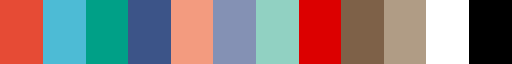

In [9]:
cmap.npg_palette

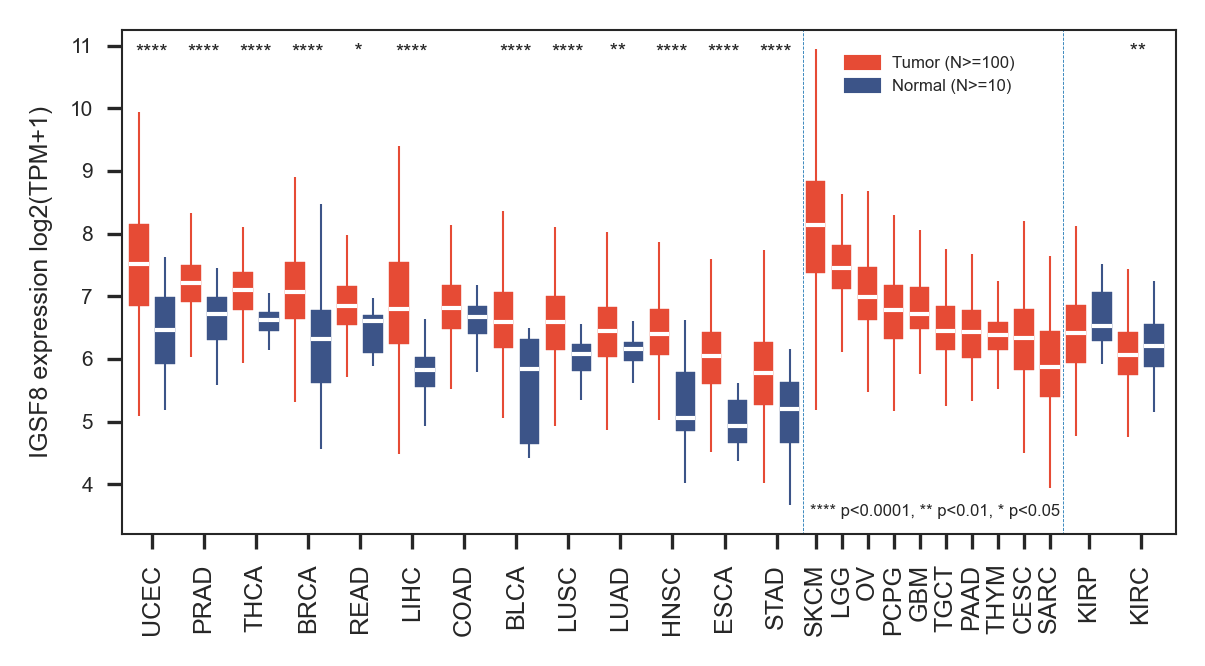

In [10]:
plt.figure(figsize=(4, 2.2))

color = [cmap.npg_palette(3) if x.endswith('Normal') else cmap.npg_palette(0) for x in IGSF8['xtick'].unique()]

ax = sns.boxplot(data=IGSF8, 
                 x='xtick',
                 y='IGSF8', 
                 palette=color, 
                 showfliers = False,
                 showcaps=False,
                 saturation=1,
                 width=0.75,
                  );

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.patches.PathPatch:
        c.set_edgecolor(color[i])
        c.set_linewidth(0.1)
        i+=1

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.lines.Line2D:        
        [c.set_linewidth(1.) if i%3==2 else c.set_linewidth(0.5)]
        if i%3==2:
            c.set_color('white')
        else:
            c.set_color(color[i//3])
        i+=1

for i, ticklabel in enumerate(ax.xaxis.get_ticklabels()):
    if ticklabel.get_text().split('.')[1]=='Normal':
        ax.text(ticklabel.get_position()[0]-1.15, 10.8, results.loc[ticklabel.get_text().split(".")[0], 'stars'],  fontsize=5) #color=cmap.Vermilion, rotation='vertical',         

xlim = ax.get_xlim()
xticks = [x.split(".")[0] for x in IGSF8['xtick'].unique()]
Xtick_tmp = pd.DataFrame([ax.get_xticks(), xticks]).T
Xtick_tmp.columns=['xticks', 'tumor']
Xtick_tmp = Xtick_tmp.groupby('tumor').mean().sort_values('xticks')

ax.set(xlabel='', ylim=(3.2,11.25), xlim=(-.65, xlim[1]+.35));
ax.set_xticks(Xtick_tmp['xticks'].astype(float).values, labels=Xtick_tmp.index.to_list());
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=6);
ax.set_ylabel('IGSF8 expression log2(TPM+1)', fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5);

ax.vlines(25.5, 2, 11.25, ls='--', lw=0.2)
ax.vlines(35.5, 2, 11.25, ls='--', lw=0.2)

from matplotlib.patches import Patch
handles = [
    Patch(edgecolor=fc, facecolor=fc, label=label, linewidth=.75) #"white"
    for label, ec, fc in zip(['Tumor (N>=100)', 'Normal (N>=10)'], [cmap.npg_palette(0), cmap.npg_palette(3)], [cmap.npg_palette(0), cmap.npg_palette(3)])
]
ax.legend(handles=handles, loc=(.68, 0.86), ncols=1, fontsize=4., frameon=False);
ax.text(25.8, 3.5, '**** p<0.0001, ** p<0.01, * p<0.05', rotation='horizontal', fontsize=4); #*** adj.p<0.001,, style='italic'
plt.savefig("../figures/Fig3A.pdf")

# Heatmap of gene correlation

In [11]:
genes = ['IGSF8', 'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'CD274',  'B2M', 'NBR1', 'SYVN1', 'TMEM129', 'SND1']
patient_data_TCGA = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad",
                                       metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                       filter_samples=100, sample_type='Tumor', genes=genes)

2024-02-22 03:21:09|INFO|dataloader|Dropping duplicates...
2024-02-22 03:21:09|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-22 03:21:09|INFO|dataloader|Take Tumor samples only.
2024-02-22 03:21:09|INFO|dataloader|Take gene expression data of ['IGSF8', 'CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'CD274', 'B2M', 'NBR1', 'SYVN1', 'TMEM129', 'SND1']
2024-02-22 03:21:09|INFO|dataloader|Filtering out patients with < 100 samples...


In [12]:
gCorr = patient_data_TCGA.to_df().join(patient_data_TCGA.obs[["project_id", "subtype", "samples.sample_type"]])
gCorr = gCorr[~gCorr['project_id'].isin(['LAML', "DLBC"])]
gCorr = gCorr.query('subtype!="BRCA_Normal"') # BRCA_Normal is classified as Tumor by cBioPortal

In [13]:
assert "Normal" not in gCorr['samples.sample_type']

In [14]:
# TCGA_project is defined as TCGA projects, an exception is BRCA, which are divided into TNBC, BRCA-LumA, BRCA-LumB, BRCA-Her2
gCorr['sample_type'] = gCorr['samples.sample_type'].map({"Solid Tissue Normal": "Normal"}).fillna("Tumor")
gCorr['TCGA_project'] = gCorr['project_id'].copy()
gCorr = gCorr[gCorr['TCGA_project'].notna()] # 118 BRCA samples do not have subtype information
gCorr["TCGA_project"] = gCorr["TCGA_project"].str.replace("_", "-")

In [15]:
from scipy.stats import (
    spearmanr,
    pearsonr,
)
from statsmodels.stats.multitest import multipletests

results = pd.DataFrame(index=pd.MultiIndex.from_product([gCorr['TCGA_project'].unique(), ['CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'CD274',  'B2M', 'NBR1', 'SYVN1', 'TMEM129', 'SND1']]), 
                       columns=["correlation", "pval", "sample_size"])

for idx in results.index:
    pid, g = idx
    subset = gCorr.query('TCGA_project==@pid')
    # rho, pval = pearsonr(subset['IGSF8'], subset[g])
    rho, pval = spearmanr(subset['IGSF8'], subset[g])
    results.loc[idx, "correlation"] = float(rho)
    results.loc[idx, "pval"] = float(pval)
    results.loc[idx, "sample_size"] = int(subset.shape[0])

results = results.rename_axis(["projects", "genes"]).reset_index()

In [16]:
results[["projects", "sample_size"]].drop_duplicates()

,projects,sample_size
0,KIRP,291
11,PAAD,179
22,BRCA,1063
33,READ,167
44,UCEC,546
55,ESCA,163
66,SARC,263
77,TGCT,156
88,PCPG,184
99,GBM,167


In [17]:
xaxis = 'projects'
x_order = ['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']
yaxis = 'genes'
y_order = ['CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1', 'CD274', 'B2M', 'NBR1', 'SYVN1', 'TMEM129', 'SND1']

In [18]:
x_to_num = {p[1]:p[0] for p in enumerate(x_order)} 
y_to_num = {p[1]:p[0] for p in enumerate(y_order[::-1])}

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_lim = [-.5,.5]
vals = results['correlation'].values.flatten()
vals = np.array(vals, dtype="float64")

if color_lim is None:
    max_val = np.nanmax(vals)
    min_val = np.nanmin(vals)
elif type(color_lim) == list:
    min_val, max_val = color_lim
    print(color_lim)
    
offset = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=0., vmax=max_val);
cmap_heatmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', list(zip([0, 0.5, 1], [cmap.npg_palette(3), cmap.npg_palette(10), cmap.npg_palette(0)])))
colors= cmap_heatmap(offset(vals))

[-0.5, 0.5]


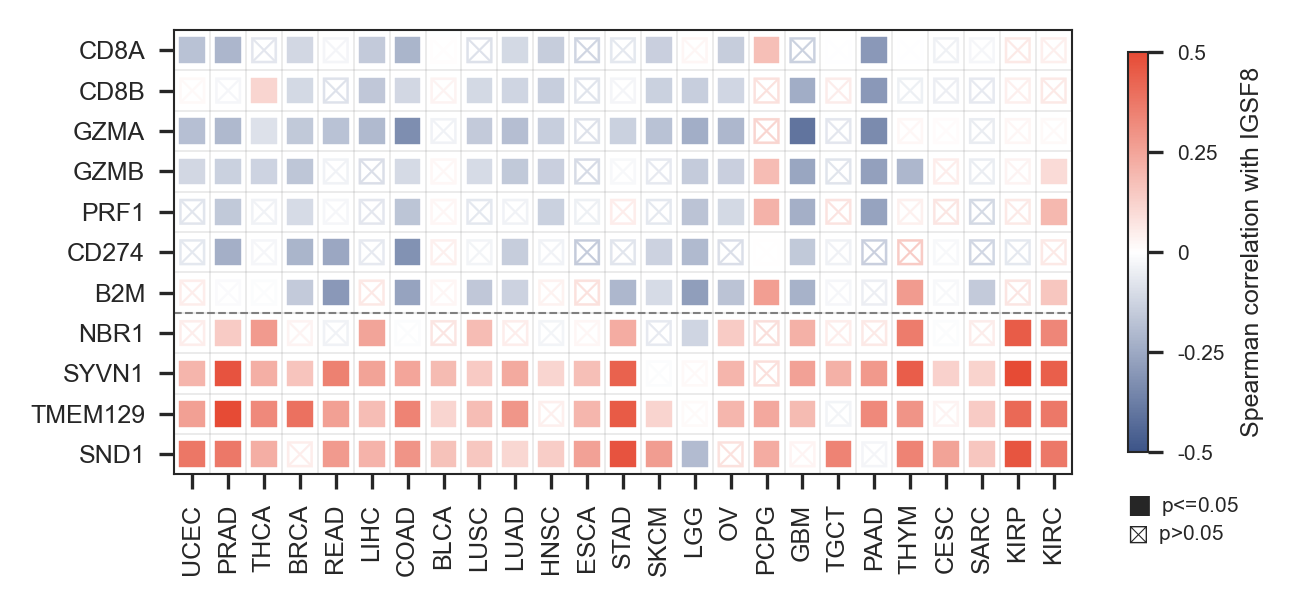

In [20]:
width = 4.4
height = 2

fig, dot_ax = plt.subplots(figsize=(width, height))
marker_mask = results['pval']<=0.05

scatter = dot_ax.scatter(x = results[xaxis].map(x_to_num)[marker_mask],
                         y = results[yaxis].map(y_to_num)[marker_mask],
                         s = 38,
                         # s = sizes[marker_mask],
                         marker='$\u2b1b$', #'s', #'$\u25A0$', #matplotlib.markers(markers) # Use square as scatterplot marker
                         linewidth=0.1,
                         c = colors[marker_mask],
                         cmap=cmap_heatmap,
                        )

scatter = dot_ax.scatter(x = results[xaxis].map(x_to_num)[~marker_mask],
                         y = results[yaxis].map(y_to_num)[~marker_mask],
                         s=38,
                         # s = sizes[~marker_mask],
                         marker='$\u22A0$', #matplotlib.markers(markers) # Use square as scatterplot marker
                         linewidth=0.1,
                         c = colors[~marker_mask],
                         cmap=cmap_heatmap,
                        )

scatter.set_cmap(cmap_heatmap)
dot_ax.set(xlim=(-0.5, len(x_order)-.5), ylim=(-0.5, len(y_order)-.5))

dot_ax.set_xticks(list(x_to_num.values()), list(x_to_num.keys()), rotation=90, horizontalalignment='center', fontsize=6);
dot_ax.set_yticks(list(y_to_num.values()), list(y_to_num.keys()), fontsize=6);
dot_ax.axhline(y=3.5, ls='--', lw=0.5, c='gray')

[dot_ax.axhline(y=y+0.5, lw=0.075, c='gray') for y in range(len(y_order))];
[dot_ax.axvline(x=x+0.5, lw=0.075, c='gray') for x in range(len(x_order))];

# plot colorbar
cbar = plt.colorbar(scatter, shrink=0.9)
cbar.set_label("Spearman correlation with IGSF8", fontsize=6);
cbar.norm((min_val, max_val))
cbar.set_ticks([0,.25, 0.5, .75, 1])
cbar.set_ticklabels([-.5,-.25, 0, .25, .5])
cbar.ax.tick_params(labelsize=5)

cbar.ax.text(0, -.15, '$\u2b1b$' + '  p<=0.05', fontsize=5, fontweight='ultralight')
cbar.ax.text(0, -.22, '$\u22A0$'+'  p>0.05', fontsize=5, fontweight='ultralight')

plt.savefig('../figures/Fig3C.pdf', bbox_inches = "tight")

# Copy number variation - IGSF8

In [21]:
focal_cnv = pd.read_csv("../OncoMark/data/datasets/IGSF8_alterations_across_samples.tsv", sep="\t")
patient_meta_cBio = pd.read_csv("../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
focal_cnv["TCGA_project"] = focal_cnv["Patient ID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])
focal_cnv["IGSF8: AMP"] = focal_cnv["IGSF8: AMP"] == "AMP"
focal_cnv["IGSF8: HOMEDEL"] = focal_cnv["IGSF8: HOMDEL"] == "HOMDEL"
focal_cnv_amp_rate = focal_cnv.groupby("TCGA_project").sum()[["IGSF8: AMP"]] / focal_cnv.groupby("TCGA_project").count()[["IGSF8: AMP"]]
focal_cnv_del_rate = focal_cnv.groupby("TCGA_project").sum()[["IGSF8: HOMEDEL"]] / focal_cnv.groupby("TCGA_project").count()[["IGSF8: HOMEDEL"]]

In [22]:
CNV_rate = focal_cnv_amp_rate.join(focal_cnv_del_rate) * 100
CNV_rate = CNV_rate.reindex(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC'])
CNV_rate.columns= ["Amplification", "Deletion"]
CNV_rate = CNV_rate[~CNV_rate.index.isin(["DLBC", "LAML"])]
CNV_rate =  CNV_rate.loc[CNV_rate[["Amplification", "Deletion"]].sum(axis=1).sort_values(ascending=False).index]
CNV_rate.head()

,Amplification,Deletion
TCGA_project,,
BLCA,11.678832,0.0
LIHC,9.946237,0.0
BRCA,8.856089,0.0
LUAD,6.537102,0.0
SARC,5.490196,0.0


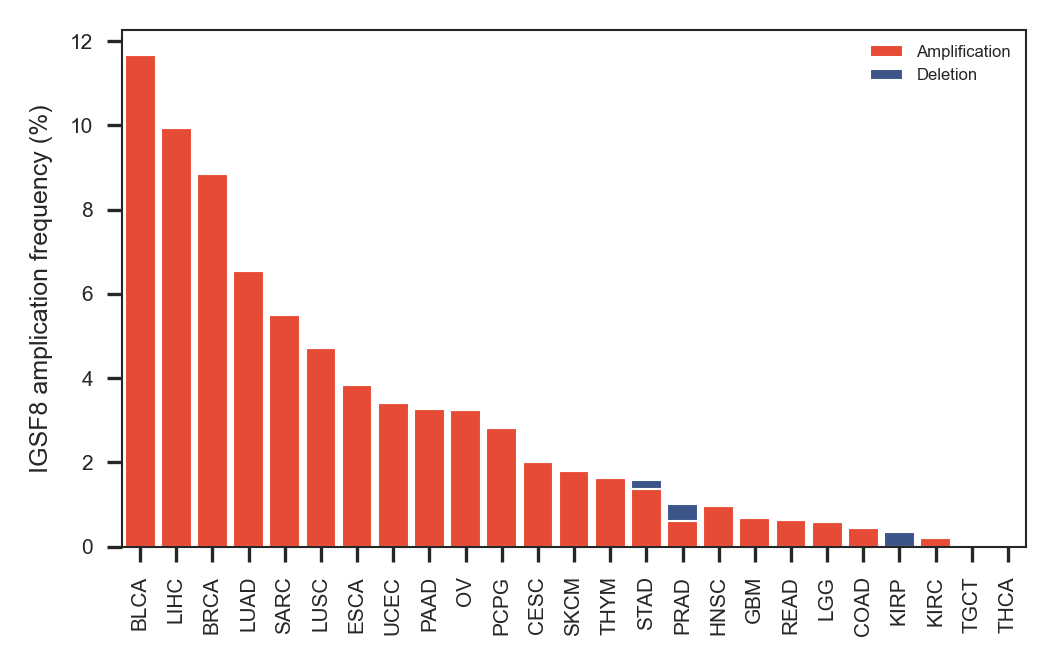

In [23]:
cmap = oma.pl.cmap()
width = .85

fig, ax = plt.subplots(figsize = (3.5, 2.2))
bottom = np.zeros(CNV_rate.shape[0])

for col, color in zip(CNV_rate.columns, [cmap.npg_palette(0), cmap.npg_palette(3)]):
    p = ax.bar(CNV_rate.index, CNV_rate[col], width, label=col, bottom=bottom, color=color, linewidth=.5)
    bottom += CNV_rate[col].values
ax.set_xlim(-0.5, CNV_rate.shape[0]-.5)
ax.set_ylim(0., CNV_rate.sum(axis=1).max()*1.05)
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="", ylabel="IGSF8 amplication frequency (%)");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', )
plt.savefig("../figures/FigS3D.pdf", bbox_inches = "tight")

# Copy number variation and gene expression

In [24]:
IGSF8_cn = pd.read_csv("../OncoMark/data/datasets/IGSF8_cna.txt", sep="\t")
IGSF8_cn["Patient ID"] = ["-".join(sid.split("-")[:3]) for sid in IGSF8_cn["SAMPLE_ID"]]
patient_meta_cBio = pd.read_csv("../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
IGSF8_cn["TCGA_project"] = IGSF8_cn["Patient ID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])
IGSF8_cn['IGSF8'] = IGSF8_cn['IGSF8'].replace('NP', np.nan)

In [25]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=100,
                                             sample_type="Tumor",
                                             genes=["IGSF8"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","subtype", "samples.sample_type", "submitter_id"]])
IGSF8_tumor = IGSF8_tumor.set_index("submitter_id")
IGSF8_tumor = IGSF8_tumor[~IGSF8_tumor.index.duplicated()]

2024-02-22 03:21:10|INFO|dataloader|Dropping duplicates...
2024-02-22 03:21:10|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-22 03:21:10|INFO|dataloader|Take Tumor samples only.
2024-02-22 03:21:10|INFO|dataloader|Take gene expression data of ['IGSF8']
2024-02-22 03:21:10|INFO|dataloader|Filtering out patients with < 100 samples...


In [26]:
IGSF8_cn['IGSF8_mRNA'] = IGSF8_cn['Patient ID'].map(IGSF8_tumor["IGSF8"])

In [27]:
IGSF8_cn = IGSF8_cn[IGSF8_cn['TCGA_project'].isin(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC'])].dropna()

idx = IGSF8_cn[['TCGA_project', 'IGSF8']].groupby('TCGA_project').apply(lambda ds: np.mean(ds['IGSF8'].astype(float))).sort_values(ascending=False).index

from pandas.api.types import CategoricalDtype
pid_cat_type = CategoricalDtype(categories=idx, ordered=True)
IGSF8_cn['TCGA_project'] = IGSF8_cn['TCGA_project'].astype(pid_cat_type)

In [28]:
IGSF8_cn[['IGSF8', 'IGSF8_mRNA']].corr()

,IGSF8,IGSF8_mRNA
IGSF8,1.000000,0.234408
IGSF8_mRNA,0.234408,1.000000


In [29]:
cn_cat_type = CategoricalDtype(categories=[-2, -1, 0, 1, 2], ordered=True)
IGSF8_cn['IGSF8'] = IGSF8_cn['IGSF8'].astype(float).astype(cn_cat_type)

In [30]:
from scipy import stats
rho, p = stats.spearmanr(IGSF8_cn["IGSF8"], IGSF8_cn["IGSF8_mRNA"])

In [31]:
xlabels = {-2: "Deep\ndeletion (-2)",
-1: "Shallow\ndeletion (-1)",
0: "Diploid\n(0)",
1: "Gain\n(1)",
2: "Amplification\n(2)"}

In [32]:
sns.set_palette("colorblind")
color_pal = sns.color_palette("RdBu", 25)

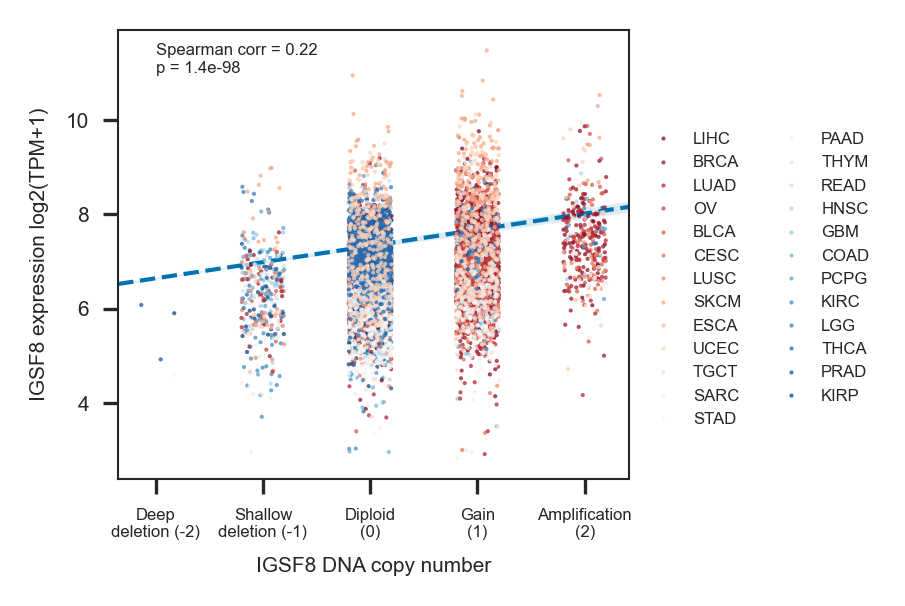

In [33]:
plt.figure(figsize=(3, 2))

ax = sns.stripplot(x='IGSF8', y='IGSF8_mRNA', data=IGSF8_cn, s=1, alpha=.75, jitter=.2, hue='TCGA_project', palette=color_pal)
sns.regplot(x='IGSF8', y='IGSF8_mRNA', data=IGSF8_cn, scatter=False, truncate=False, line_kws={'ls': '--', 'lw':1})
ax.set_xticklabels(xlabels.values(), rotation_mode='anchor', fontsize=4)
ax.set_xlabel("IGSF8 DNA copy number", fontsize=5)
ax.set_ylabel("IGSF8 expression log2(TPM+1)", fontsize=5)
ax.legend(loc=(1.02, .1), ncols=2, fontsize=4, frameon=False)
ax.text(0, 11, f"Spearman corr = {rho:.2f}\np = {p:.1e}", fontsize=4)
plt.savefig('../figures/FigS3E.pdf')

# CCLE

In [34]:
ccle_sample_info = pd.read_excel('../OncoMark/data/datasets/CCLE/CCLE_Nature_2019.xlsx', sheet_name='Cell Line Annotations')

ccle_pro_cbio = pd.read_csv('../OncoMark/data/datasets/CCLE/data_protein_quantification.txt', sep='\t', index_col=0)
ccle_pro_cbio.index = [idx.split("|")[0] for idx in ccle_pro_cbio.index]
ccle_pro_cbio = ccle_pro_cbio.stack().to_frame('values').rename_axis(['genes', 'cell_lines']).reset_index().groupby(["cell_lines", "genes"]).sum().unstack()
ccle_pro_cbio.columns = ccle_pro_cbio.columns.droplevel(0)

ccle_mrna = pd.read_csv('../OncoMark/data/datasets/CCLE/CCLE_RNAseq_rsem_genes_tpm_20180929.txt.gz', sep='\t', index_col=0)

shared_cell_lines = ccle_mrna.columns.intersection(ccle_sample_info["CCLE_ID"])
ccle_mrna = ccle_mrna[shared_cell_lines]
ccle_mrna = np.log2(ccle_mrna + 1)

In [35]:
IGSF8 = ccle_pro_cbio['IGSF8'].to_frame('protein abundance').join(ccle_mrna[ccle_mrna.index.str.contains('ENSG00000162729')].T)
IGSF8.rename(columns={'ENSG00000162729.9': 'mRNA levels'}, inplace=True)
IGSF8['cancer types']=IGSF8.index.map(dict(ccle_sample_info[['CCLE_ID', 'tcga_code']].values))

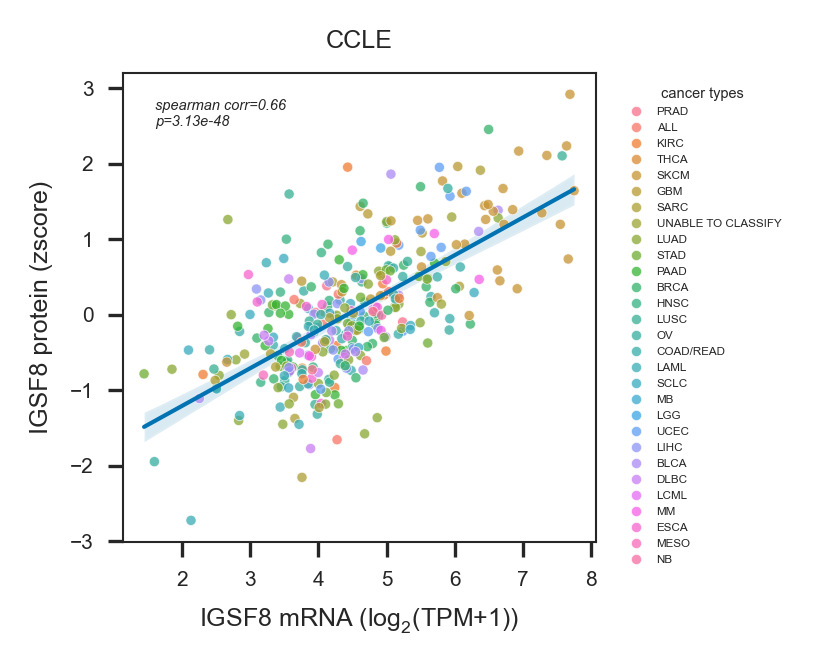

In [36]:
rho, pval = stats.pearsonr(IGSF8[['protein abundance', 'mRNA levels']].dropna()['protein abundance'].values, 
                           IGSF8[['protein abundance', 'mRNA levels']].dropna()['mRNA levels'].values)

plt.figure(figsize=(2.7, 2.2))
ax = sns.regplot(x="mRNA levels", 
                 y="protein abundance",
                 data=IGSF8, 
                 y_jitter=.03,
                 scatter=False,
                 line_kws={"linewidth":1}
                );
ax = sns.scatterplot(data=IGSF8,
                     x='mRNA levels',
                     y='protein abundance',
                     hue="cancer types",
                     s=6,
                     alpha=.75,
                     color=cmap.npg_palette(0)
                    )
sns.move_legend(ax, loc=(1.05, -.06), frameon=False, ncols=1, title="cancer types", title_fontsize=3.5, fontsize=2.8)
ax.text(1.6, 2.5, f"spearman corr={rho:.2f}\np={pval:.2e}", fontsize=3.5, fontstyle="italic")
ax.set(xlabel="IGSF8 mRNA (log$_{2}$(TPM+1))", ylabel="IGSF8 protein (zscore)", title='CCLE')

plt.savefig("../figures/FigS3K.pdf", bbox_inches = "tight")

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_90344/3410842195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccle_prot_B2M_IGSF8['cancer types']=ccle_prot_B2M_IGSF8.index.map(dict(ccle_sample_info[['CCLE_ID', 'tcga_code']].values))


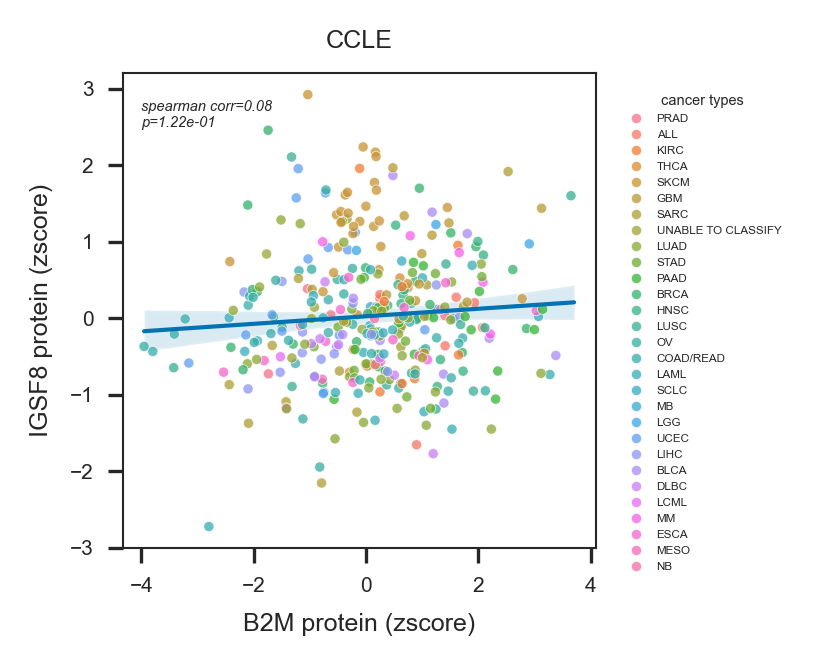

In [37]:
ccle_prot_B2M_IGSF8 = ccle_pro_cbio[["B2M", "IGSF8"]]
ccle_prot_B2M_IGSF8['cancer types']=ccle_prot_B2M_IGSF8.index.map(dict(ccle_sample_info[['CCLE_ID', 'tcga_code']].values))

rho, pval = stats.pearsonr(ccle_prot_B2M_IGSF8[["B2M", "IGSF8"]].dropna()['B2M'].values, 
                           ccle_prot_B2M_IGSF8[["B2M", "IGSF8"]].dropna()['IGSF8'].values)

plt.figure(figsize=(2.7, 2.2))
ax = sns.regplot(x="B2M", 
                 y="IGSF8",
                 data=ccle_prot_B2M_IGSF8, 
                 y_jitter=.03,
                 scatter=False,
                 line_kws={"linewidth":1}
                );
ax = sns.scatterplot(data=ccle_prot_B2M_IGSF8,
                     x='B2M',
                     y='IGSF8',
                     hue="cancer types",
                     s=6,
                     alpha=.75,
                     color=cmap.npg_palette(0)
                    )

sns.move_legend(ax, loc=(1.05, -.06), frameon=False, ncols=1, title="cancer types", title_fontsize=3.5, fontsize=2.8)
ax.text(-4, 2.5, f"spearman corr={rho:.2f}\np={pval:.2e}", fontsize=3.5, fontstyle="italic")
ax.set(xlabel="B2M protein (zscore)", ylabel="IGSF8 protein (zscore)", title='CCLE')

plt.savefig("../figures/FigS3M.pdf", bbox_inches = "tight")

# CPTAC

In [38]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=10, 
                                             sample_type="Tumor", 
                                             genes=["IGSF8"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["submitter_id"]])
IGSF8_tumor = IGSF8_tumor.groupby("submitter_id").mean()

2024-02-22 03:21:19|INFO|dataloader|Dropping duplicates...
2024-02-22 03:21:19|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-22 03:21:19|INFO|dataloader|Take Tumor samples only.
2024-02-22 03:21:19|INFO|dataloader|Take gene expression data of ['IGSF8']
2024-02-22 03:21:19|INFO|dataloader|Filtering out patients with < 10 samples...


In [39]:
BRCA_CPTAC = pd.read_csv('../OncoMark/data/datasets/CPTAC_OV_BRCA/BRCA.data_protein_quantification_zscores.txt.gz', index_col=0).T
BRCA_CPTAC["cancer types"] = "BRCA"
OV_CPTAC = pd.read_csv('../OncoMark/data/datasets/CPTAC_OV_BRCA/OV.data_protein_quantification_zscores.txt.gz', index_col=0).T
OV_CPTAC["cancer types"] = "OV"
CPTAC_prot_B2M_IGSF8 = pd.concat([BRCA_CPTAC, OV_CPTAC])[["IGSF8", "B2M", "cancer types"]]

In [40]:
CPTAC_prot_mRNA = CPTAC_prot_B2M_IGSF8.copy()
CPTAC_prot_mRNA['submitter_id'] = CPTAC_prot_mRNA.index.str[:-3]
CPTAC_prot_mRNA["IGSF8_mRNA"] = CPTAC_prot_mRNA['submitter_id'].map(IGSF8_tumor["IGSF8"])

In [41]:
CPTAC_prot_mRNA

Gene,IGSF8,B2M,cancer types,submitter_id,IGSF8_mRNA
TCGA-A2-A0D0-01,-0.3627,0.5588,BRCA,TCGA-A2-A0D0,5.980440
TCGA-BH-A0HK-01,-0.6535,-0.5721,BRCA,TCGA-BH-A0HK,6.621542
TCGA-C8-A12T-01,-1.1205,0.1499,BRCA,TCGA-C8-A12T,6.355685
TCGA-A2-A0D2-01,1.1419,-0.3167,BRCA,TCGA-A2-A0D2,6.516850
TCGA-C8-A12U-01,1.1927,1.8271,BRCA,TCGA-C8-A12U,8.297936
...,...,...,...,...,...
TCGA-36-2545-01,-0.6607,2.3187,OV,TCGA-36-2545,NaN
TCGA-25-2404-01,0.2384,0.6570,OV,TCGA-25-2404,7.699903
TCGA-24-1430-01,-0.4760,0.2217,OV,TCGA-24-1430,7.136637
TCGA-29-1697-01,-0.2102,-0.6556,OV,TCGA-29-1697,7.292813


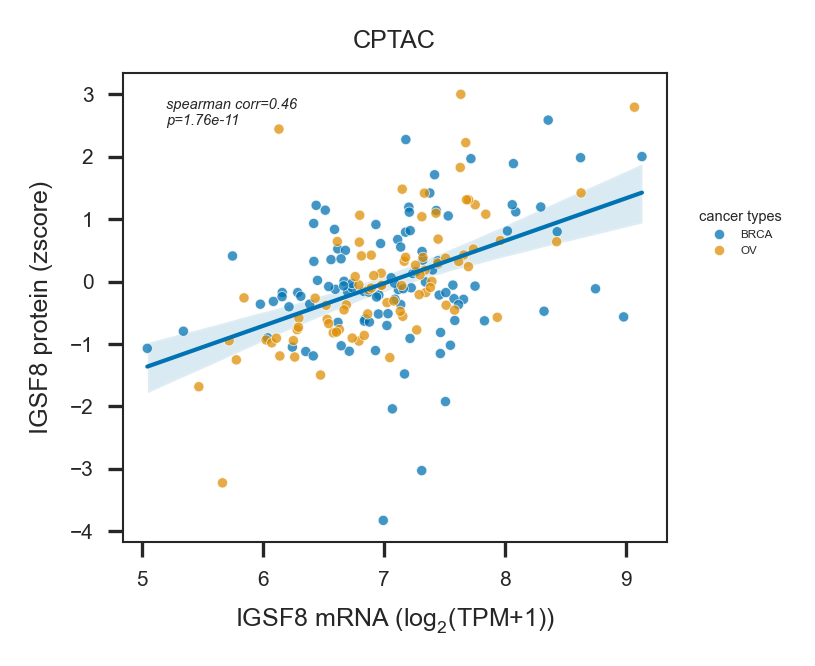

In [42]:
rho, pval = stats.pearsonr(CPTAC_prot_mRNA[["IGSF8_mRNA", "IGSF8"]].dropna()['IGSF8_mRNA'].values, 
                           CPTAC_prot_mRNA[["IGSF8_mRNA", "IGSF8"]].dropna()['IGSF8'].values)

plt.figure(figsize=(2.7, 2.2))
ax = sns.regplot(x="IGSF8_mRNA", 
                 y="IGSF8",
                 data=CPTAC_prot_mRNA, 
                 y_jitter=.03,
                 scatter=False,
                 line_kws={"linewidth":1}
                );
ax = sns.scatterplot(data=CPTAC_prot_mRNA,
                     x='IGSF8_mRNA',
                     y='IGSF8',
                     hue="cancer types",
                     s=6,
                     alpha=.75,
                     color=cmap.npg_palette(0)
                    )

sns.move_legend(ax, loc=(1.05, .6), frameon=False, ncols=1, title="cancer types", title_fontsize=3.5, fontsize=2.8)
ax.text(5.2, 2.5, f"spearman corr={rho:.2f}\np={pval:.2e}", fontsize=3.5, fontstyle="italic")
ax.set(xlabel="IGSF8 mRNA (log$_{2}$(TPM+1))", ylabel="IGSF8 protein (zscore)", title='CPTAC') #ylim=(None, 1.05), 

plt.savefig("../figures/FigS3L.pdf", bbox_inches = "tight")

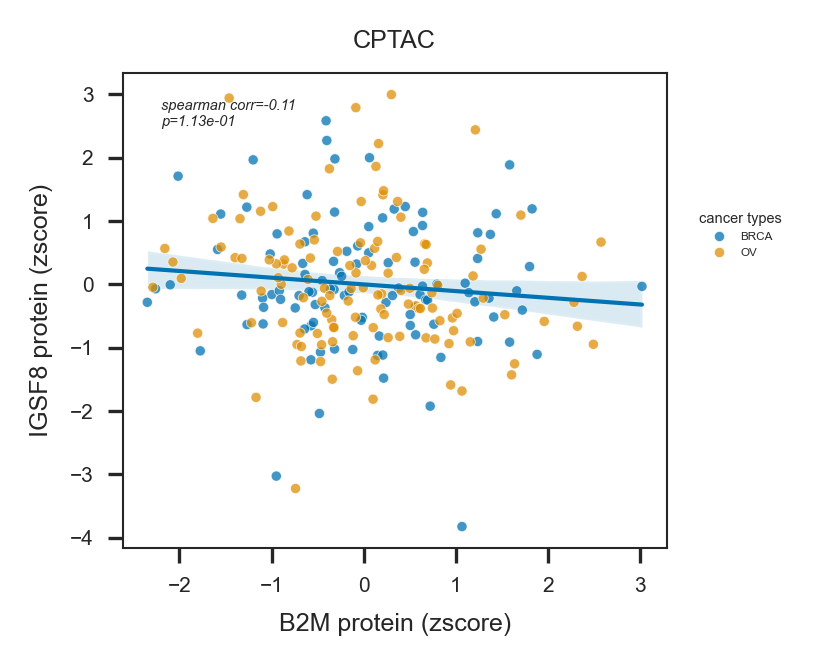

In [43]:
rho, pval = stats.pearsonr(CPTAC_prot_B2M_IGSF8[["B2M", "IGSF8"]].dropna()['B2M'].values, 
                           CPTAC_prot_B2M_IGSF8[["B2M", "IGSF8"]].dropna()['IGSF8'].values)

plt.figure(figsize=(2.7, 2.2))
ax = sns.regplot(x="B2M", 
                 y="IGSF8",
                 data=CPTAC_prot_B2M_IGSF8, 
                 y_jitter=.03,
                 scatter=False,
                 line_kws={"linewidth":1}
                );
ax = sns.scatterplot(data=CPTAC_prot_B2M_IGSF8,
                     x='B2M',
                     y='IGSF8',
                     hue="cancer types",
                     s=6,
                     alpha=.75,
                     color=cmap.npg_palette(0)
                    )

sns.move_legend(ax, loc=(1.05, .6), frameon=False, ncols=1, title="cancer types", title_fontsize=3.5, fontsize=2.8)
ax.text(-2.2, 2.5, f"spearman corr={rho:.2f}\np={pval:.2e}", fontsize=3.5, fontstyle="italic")
ax.set(xlabel="B2M protein (zscore)", ylabel="IGSF8 protein (zscore)", title='CPTAC') #ylim=(None, 1.05), 

plt.savefig("../figures/FigS3N.pdf", bbox_inches = "tight")